# Mineração de Dados - 2018.2
----

## Dependências

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import IsolationForest

In [2]:
STR_FORMAT = '%Y-%m-%d %H:%M:%S'

## Métodos Auxiliares

In [3]:

def get_date(ts):
    date = datetime.fromtimestamp(ts).strftime(STR_FORMAT)
    return date


def drop_invalid_columns(df):
    colsdrop = ['Unnamed: 0', 'VAR19', 'VAR29', 'VAR30']
    df = df.drop(colsdrop, axis=1)
    return df


def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_correlations(df, n=5, asc=False, absolute=False):
    au_corr = df.corr().abs().unstack() if absolute else df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=asc)
    return au_corr[0:n]


ranges = {}
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        ranges[feature_name] = (min_value, max_value)
        
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def denormalize(df):
    result = df.copy()
    for feature_name in df.columns:
        result[feature_name] = df[feature_name] * (ranges[feature_name][1] - ranges[feature_name][0]) + ranges[feature_name][0]
    return result

def get_anomalies(base, reprovados=False):
    # Base de dado com e sem headers
    sample = base.copy()
    sample.columns = range(sample.shape[1])
    
    #Isolation Forest
    clf = IsolationForest(max_samples='auto', contamination=0.08, n_jobs=-1)
    clf.fit(sample)
    
    # Deteccao de anomalias
    scores = clf.decision_function(sample)
    predict  = clf.predict(sample)
    num_outliers = predict.tolist().count(-1)
    
    outliers = []
    outliers_position = []
    while len(outliers) < num_outliers:
        outliers.append(scores.min())
        
        outliers_position.append(scores.argmin()+1)
        scores = np.delete(scores, scores.argmin())
    
    # Anomalias encontradas    
    anomalias = base.iloc[outliers_position]
    anomalias = anomalias.sort_values(
            by=['DESEMPENHO'],
            ascending=False
            )
    anomalias = anomalias.drop_duplicates()
    # Correlacoes
    anomalias_aprovados = anomalias.loc[anomalias['DESEMPENHO_BINARIO']==0]
    corr_aprovados = get_top_correlations(anomalias_aprovados, 4000, absolute=True)
    
    if reprovados:
        anomalias_reprovados = anomalias.loc[anomalias['DESEMPENHO_BINARIO']==1]
        corr_reprovados = anomalias_reprovados.corr()
        corr_reprovados = corr_reprovados['DESEMPENHO']
        
        corr = pd.concat([corr_aprovados, corr_reprovados], axis=1)
        corr.columns = ["DESEMPENHO_APROVADOS", "DESEMPENHO_REPROVADOS"]
        
        return anomalias_aprovados, anomalias_reprovados, corr
        
    return anomalias_aprovados, corr_aprovados, None, None


def bar_plot_series(serie, name, save=False):
    plt.figure(figsize=(20,10))
    serie.plot.bar()
    if save:
        plt.savefig('./Outputs/Figuras/'+name+'.svg', bbox_inches='tight')
        return
    plt.show()

def heatmap(df, title, ax):
    plt.title(title)
    corr = df.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            ax=ax)


## Modelagem
----

In [4]:
# Carregar Dados

base = '../Base/Subsets/basePedagogia.csv'
df_base = pd.read_csv(base, sep=';', decimal=',', index_col=False)
df_base = drop_invalid_columns(df_base)

In [5]:
# Seleção

df_base = df_base.sort_values(
        by=['VAR31', 'VAR24', 'DESEMPENHO'],
        ascending=False
        )
df_base.head()

,CURSO,SEMESTRE,PERIODO,NOME_DA_DISCIPLINA,ID_DA_DISCIPLINA,DATA_DE_INICIO,DATA_DE_FINAL,ID_DO_ALUNO,VAR01,VAR02,...,FORUM04,MEDIA_FORUM,WEBQUEST01,WEBQUEST02,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO,MEDIA_CALCULADA_PROVA,MEDIA_CALCULADA_FORUM,TEMPO_DE_CURSO
977,Pedagogia,2011.1,2,Filosofia da Educação,33,2010-12-31 21:00:00,2011-06-30 20:59:59,133,29,0,...,5,1.00,3,6,1.125,6.80,0,8.5,5.00,180 days 23:59:59.000000000
1617,Pedagogia,2011.1,2,Prática Pedagógica II,36,2010-12-31 21:00:00,2011-06-30 20:59:59,133,29,0,...,0,0.75,6,5,1.375,6.53,0,8.0,3.75,180 days 23:59:59.000000000
1766,Pedagogia,2011.1,2,Psicologia da Aprendizagem,34,2010-12-31 21:00:00,2011-06-30 20:59:59,133,29,0,...,5,0.85,4,6,1.250,6.50,0,8.0,4.25,180 days 23:59:59.000000000
1318,Pedagogia,2011.1,2,Informática na Educação,35,2010-12-31 21:00:00,2011-06-30 20:59:59,133,29,0,...,5,0.95,4,4,1.000,6.08,0,7.5,4.75,180 days 23:59:59.000000000
1148,Pedagogia,2011.1,2,História da Educação,32,2010-12-31 21:00:00,2011-06-30 20:59:59,133,29,0,...,4,0.60,2,4,0.750,5.75,0,8.0,3.00,180 days 23:59:59.000000000


### - Variaveis de Interesse
---
| Variável        | Significado | Categoria |
| --------------- | ----------- | --------- |
| VAR02           | Quantidade de mensagens enviadas por aluna(o) às(os) Professoras(es) pelo ambiente.  | Busca por Ajuda
| VAR03           | Quantidade de mensagens enviadas por aluna(o) às(os) Tutor(es) pelo ambiente.        | Busca por Ajuda
| VAR04           | Quantidade geral de mensagens enviadas pela(o) aluna(o) dentro do ambiente.          | Busca por Ajuda
| VAR06           | Quantidade de tópicos criados pelo(a) aluno(a) em fórum do tipo "tira-dúvidas".      | Busca por Ajuda
| VAR07           | Quantidade de postagens no "Fórum tira dúvidas".                                     | Busca por Ajuda
| VAR16           | Quantidade de atividades entregues por um(a) aluno(a) fora do prazo, por disciplina. | Estratégia de Realização de Tarefa
| VAR18           | Quantidade de leituras feitas ao fórum (pageviews).                                  | Estratégia de Realização de Tarefa
| VAR20           | Quantidade de respostas ao tópico principal (refazer opinião em fórum).              | Autoavaliação
| VAR24           | Média semanal da quantidade de acessos de um(a) aluno(a) ao ambiente.                | Gestão do Tempo
| VAR31           | Quantidade de acessos do(a) aluno(a) ao ambiente.                                    | Gestão do Tempo
| VAR33           | Quantidade de atividades entregues por um(a) aluno(a) no prazo, por disciplina.      | Estabelecimento de metas
| VAR34           | Quantidade geral de postagens de um(a) aluno(a) em fóruns.                           | Estabelecimento de metas
| DESEMPENHO      | 0.55\*MEDIA_PROVAS + 0.2\*MEDIA_FORUM + 0.25\*MEDIA_WEBQUEST                         | Avaliação

In [12]:
df_clean = df_base[['VAR02', 'VAR03', 'VAR04','VAR06', 'VAR07', 'VAR16','VAR18', 'VAR20',
                   'VAR24', 'VAR31', 'VAR33', 'VAR34', 'MEDIA_PROVAS', 'MEDIA_FORUM', 
                   'MEDIA_WEBQUEST', 'DESEMPENHO', 'DESEMPENHO_BINARIO']]

df_clean.sort_values(by="DESEMPENHO", ascending=False).head(10)

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,VAR33,VAR34,MEDIA_PROVAS,MEDIA_FORUM,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
12837,0,0,1,0,0,0,70,0,7.0,185,2,5,5.5,2.0,3.0,10.5,0
13332,1,0,12,0,0,0,22,0,5.0,140,2,4,5.5,2.0,3.0,10.5,0
13034,0,0,0,0,0,0,19,0,3.0,88,2,4,5.5,2.0,3.0,10.5,0
12404,0,0,1,0,0,0,89,0,7.0,185,2,4,5.5,2.0,3.0,10.5,0
3625,0,0,0,0,0,0,42,0,3.0,94,2,4,5.5,2.0,3.0,10.5,0
13161,2,0,4,0,0,0,39,0,2.0,77,2,4,5.5,2.0,3.0,10.5,0
13630,0,0,0,0,0,0,16,0,2.0,72,2,4,5.5,2.0,3.0,10.5,0
12237,0,0,35,0,0,0,221,0,12.0,326,2,7,5.5,2.0,3.0,10.5,0
13612,0,0,0,0,0,0,19,0,4.0,118,2,4,5.5,1.9,3.0,10.4,0
13474,0,0,0,0,0,0,20,0,4.0,112,2,4,5.5,1.9,3.0,10.4,0


## Análise
----

### - Normalização

In [7]:
df_clean_norm = normalize(df_clean)
df_clean_norm.head()

,VAR02,VAR03,VAR04,VAR06,VAR07,VAR16,VAR18,VAR20,VAR24,VAR31,VAR33,VAR34,MEDIA_PROVAS,MEDIA_FORUM,MEDIA_WEBQUEST,DESEMPENHO,DESEMPENHO_BINARIO
977,0.0,0.256983,0.146988,0.0,0.0,0.0,0.218631,0.000,1.0,1.0,1.0,0.173913,0.850909,0.500,0.375000,0.647619,0.0
1617,0.0,0.256983,0.146988,0.0,0.0,0.0,0.315589,0.125,1.0,1.0,1.0,0.260870,0.800000,0.375,0.458333,0.621905,0.0
1766,0.0,0.256983,0.146988,0.0,0.0,0.0,0.209125,0.125,1.0,1.0,1.0,0.304348,0.800000,0.425,0.416667,0.619048,0.0
1318,0.0,0.256983,0.146988,0.0,0.0,0.0,0.231939,0.125,1.0,1.0,1.0,0.217391,0.750909,0.475,0.333333,0.579048,0.0
1148,0.0,0.256983,0.146988,0.0,0.0,0.0,0.484791,0.125,1.0,1.0,1.0,0.217391,0.800000,0.300,0.250000,0.547619,0.0


### - Detecção de Anomalias

In [8]:
anomalias_aprovados_norm, correlacoes_aprovados, _, _ = get_anomalies(df_clean_norm)
print("Anomalias: {}".format(len(anomalias_aprovados_norm)))

Anomalias: 829


In [9]:
# Desnormalização
anomalias_aprovados_denorm = denormalize(anomalias_aprovados_norm)

## Visualização
----

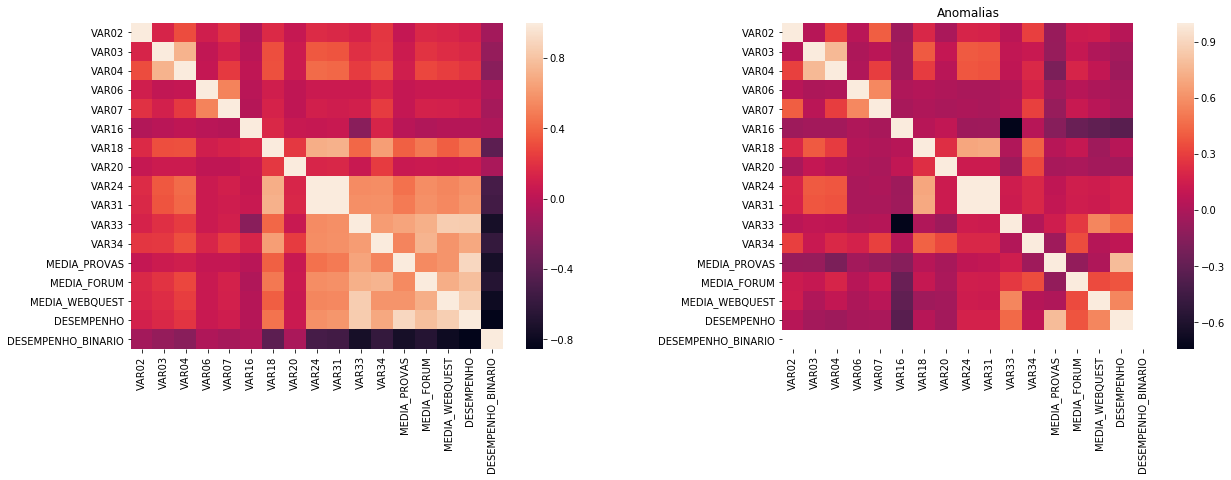

In [10]:
# Heatmap
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plt.subplots_adjust(wspace=0.4)
heatmap(df_clean_norm, "Original", ax1)
heatmap(anomalias_aprovados_norm, "Anomalias", ax2)